# 1.GPT模型的架构

In [1]:
'''124M GPT-2的参数设置'''
GPT_CONFIG_124M = {
    "vocab_size": 50527, #vocabulary size
    "context_length": 1024, #context length
    "emb_dim": 768, #embedding dimension
    "n_heads": 12, #number of attention heads
    "n_layers": 12, #number of layers(transformer blocks)
    "drop_rate": 0.1, #dropout rate
    "qkv_bias": False #query-key-value bias
}

In [10]:
'''一个虚拟的GPT模型的架构'''
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        #Transformer block
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        #Layer Normalization
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        
        #Output
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )


    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_length, device = in_idx.device))
        x = tok_embeds + pos_embeds
       
        x = self.drop_emb(x)

        x= self.trf_blocks(x)

        x = self.final_norm(x)

        logits = self.out_head(x)

        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Implementation of transformer blocks

    def forward(self, x):
        
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        #The implementation of layer normalization

    def forward(self, x):

        return x


In [ ]:
'''测试虚拟的GPT模型的输出'''

import tiktoken

# 1.构造数据
tokenizer  = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim = 0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [11]:
torch.manual_seed(123)

model =  DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

print(logits.shape)
print(logits)

torch.Size([2, 4, 50527])
tensor([[[-0.5076,  0.5526, -1.3087,  ..., -1.2430, -0.1799,  0.2840],
         [ 0.4162,  0.5258, -0.2680,  ..., -0.6662, -0.0434, -1.7204],
         [ 0.2720,  0.5737,  0.2196,  ..., -0.4875, -2.2169, -0.8551],
         [ 1.7329, -0.0533,  0.9222,  ..., -0.8311, -0.3060,  0.1644]],

        [[-0.4748,  1.0586, -0.6434,  ..., -0.9168,  0.2064, -0.3204],
         [-0.4063, -0.6273,  0.9828,  ..., -0.6344,  0.0545, -0.0326],
         [-0.2660, -1.7609,  0.6074,  ..., -1.1383, -0.7710, -0.9709],
         [ 0.5479, -1.3437,  1.2603,  ...,  0.6285, -0.2088, -2.5608]]],
       grad_fn=<UnsafeViewBackward0>)


# 2.Layer Normalization

In [ ]:
'''得到神经网络某一层的输出激活值'''
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
#查看输出激活值的均值和方差
mean = out.mean(dim = -1, keepdim = True) #keepdim参数的作用是使输出的维度和原始的维度保持一致
var = out.var(dim = -1, keepdim = True)

print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
'''使得均值为0 方差为1 的方法：减去均值并且除以方差的平方根'''
out_norm = (out - mean) / torch.sqrt(var)
print(out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [16]:
# 注意到上面进行normalization之后，均值并不严格为0，而是接近0的一个小数。
# 可以通过下面的方式实现：禁用科学计算
torch.set_printoptions(sci_mode = False)
print(mean)
print(var)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [19]:
'''Layer Normalization的实现'''
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 #用于避免出现除以0的情况
        # 下面这两个参数是可学习的参数，用于在训练过程中提升模型的性能
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

In [32]:
# 测试layer normalization
ln = LayerNorm(emb_dim = 5)

torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)


Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# 3.带GELU激活函数的FFN

In [1]:
'''GELU函数的代码实现'''
import torch.nn as nn

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):

        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.44715 * torch.pow(x, 3))
        ))

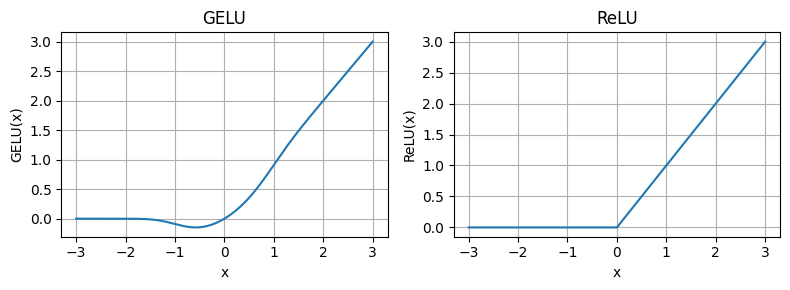

In [6]:
'''对比ReLU和GELU函数'''
import torch
gelu, relu = GELU(), nn.ReLU()

# 测试数据
x = torch.linspace(-3, 3, 1000)
y_gelu, y_relu = gelu(x), relu(x)


import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label}")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
'''FFN前向传播网络'''
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
'''124M GPT-2的参数设置'''
GPT_CONFIG_124M = {
    "vocab_size": 50527, #vocabulary size
    "context_length": 1024, #context length
    "emb_dim": 768, #embedding dimension
    "n_heads": 12, #number of attention heads
    "n_layers": 12, #number of layers(transformer blocks)
    "drop_rate": 0.1, #dropout rate
    "qkv_bias": False #query-key-value bias
}

ffn = FeedForward(GPT_CONFIG_124M)

# Dummy input:[batch_size, num_token, emb_size]
x = torch.randn(2, 3, 768)

out = ffn(x)

print(out.shape)

torch.Size([2, 3, 768])


# 4.shortcut connection

In [10]:
'''带/不带 跳跃连接深度神经网络'''
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 1.计算当前layer的输出
            layer_output = layer(x)
            # 2.检查是否启用跳跃连接
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output  # <—— 将输入与当前层的输出相加，作为下一层的输入
            else:
                x = layer_output
        
        return x
            

In [11]:
# 定义打印梯度的函数
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")



In [ ]:
# 测试
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
# 1. 不带跳跃连接的 DNN
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes=layer_sizes,
    use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)

print("=" * 50)

# 2. 带跳跃连接的DNN
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes=layer_sizes,
    use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020471324387472123
layers.1.0.weight has gradient mean of 0.0001231795467901975
layers.2.0.weight has gradient mean of 0.0007344747427850962
layers.3.0.weight has gradient mean of 0.0013871216215193272
layers.4.0.weight has gradient mean of 0.005026496481150389
layers.0.0.weight has gradient mean of 0.29920274019241333
layers.1.0.weight has gradient mean of 0.2749510407447815
layers.2.0.weight has gradient mean of 0.454661101102829
layers.3.0.weight has gradient mean of 0.3629586696624756
layers.4.0.weight has gradient mean of 1.763088583946228


# 5. transformer block

In [ ]:
from MulitHeadAttention import MultiHeadAttention
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 1.多头注意力模块
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )

        # 2.FFN模块
        self.ff = FeedForward(cfg)

        # 3.Layer Normalization模块，分别设置的原因是其中有可学习的参数
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        # 4.dropout
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Step 1:多头注意力机制, 启用跳跃连接
        shortcut = x

        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)

        x = x + shortcut #将输入加在输出上，作为下一个模块的输入

        # Step 2:前向传播网络，启用跳跃连接
        shortcut = x

        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)

        x = x + shortcut 


        return x 

In [22]:
'''测试Transformer block的输出'''

# 124M GPT-2的参数设置
GPT_CONFIG_124M = {
    "vocab_size": 50527, #vocabulary size
    "context_length": 1024, #context length
    "emb_dim": 768, #embedding dimension
    "n_heads": 12, #number of attention heads
    "n_layers": 12, #number of layers(transformer blocks)
    "drop_rate": 0.1, #dropout rate
    "qkv_bias": False #query-key-value bias
}

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)

output = block(x)

print(x.shape)
print(output.shape)


torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


# 6.GPT model

In [31]:
'''GPT模型类的实现'''
import torch.nn as nn
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # 1.token and position embedding
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # 2. dropout layer
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 3. transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # 4. layer normalization
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # 5. output linear layer

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        # 这里之所以用torch.arange()，是为了处理输入的seq_len < context_length的情况
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        
        x = self.drop_emb(x)
        
        x = self.trf_blocks(x)
        
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        return logits

In [33]:
'''测试GPT模型'''
import tiktoken

# 1.构造数据
tokenizer  = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim = 0)

print(batch)

# 2.得到模型输出
torch.manual_seed(123)
# 124M GPT-2的参数设置
GPT_CONFIG_124M = {
    "vocab_size": 50527, #vocabulary size
    "context_length": 1024, #context length
    "emb_dim": 768, #embedding dimension
    "n_heads": 12, #number of attention heads
    "n_layers": 12, #number of layers(transformer blocks)
    "drop_rate": 0.1, #dropout rate
    "qkv_bias": False #query-key-value bias
}

model = GPTModel(GPT_CONFIG_124M)

output = model(batch)
print(output.shape)
print(output)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4, 50527])
tensor([[[-0.5877,  0.8573, -0.2601,  ...,  0.3107,  0.4342,  0.8528],
         [ 0.0712, -0.1176,  0.2643,  ...,  0.1433, -0.3264, -0.1630],
         [-0.6378,  0.0947, -0.2607,  ..., -0.2314, -0.9811,  0.3972],
         [-0.2141,  0.2604, -0.2470,  ...,  0.2904, -0.5390,  0.2703]],

        [[-0.7258,  0.6511,  0.3790,  ..., -0.1726,  0.0351,  1.0781],
         [ 0.5047,  0.4110, -0.2189,  ..., -0.4933, -0.4000,  0.5538],
         [ 0.2778,  0.2747,  0.0131,  ...,  0.5906,  0.2540,  0.9131],
         [ 0.4185,  0.6752, -0.4666,  ...,  0.6094, -0.1796,  0.8730]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
'''计算模型的参数量'''
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

# Note:
# 可以发现，计算出来的参数量是163M，这和官方给的124M不一样，原因是GPT-2模型使用了
# 权重绑定技术,将token embedding layer和output layer的参数权重共享了，因为它们的shape
# 是一样的。
print(model.tok_emb.weight.shape)
print(model.out_head.weight.shape)

# 那么，如果将token embedding layer或者output layer的参数，减掉其中一个，就可以了
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(total_params_gpt2) #这才是实际的模型参数量

163424256
torch.Size([50527, 768])
torch.Size([50527, 768])
124619520


In [ ]:
'''计算模型的内存占用量'''
# 假设使用float32精度，每个参数占4个字节（byte）。
total_size_bytes = total_params * 4

# 转换为M
total_size_M = total_size_bytes / (1024 * 1024)
print(total_size_M)

623.4140625


## 练习

### 练习4.1 计算多头注意力模块和输出头模块的参数量

In [ ]:
attn_params = sum(p.numel() for p in model.trf_blocks.parameters())
print(attn_params)

ffn_params = sum(p.numel() for p in model.out_head.parameters())
print(ffn_params)

print(attn_params + ffn_params)


85026816
38804736
123831552


In [ ]:
# 计算 一个 transformer block中多头注意力模块和FFN模块的参数量
transformer_block = TransformerBlock(GPT_CONFIG_124M)
print(transformer_block)#输出transformer block的结构

# 计算多头注意力模块的参数量
mha_params = sum(p.numel() for p in transformer_block.att.parameters())
print(mha_params)

# 计算前向传播网络模块的参数量
ffn_params = sum(p.numel() for p in transformer_block.ff.parameters())
print(ffn_params)

TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_shortcut): Dropout(p=0.1, inplace=False)
)
2360064
4722432


1.上述一个transformer block参数量计算的过程：
<div align="center" >
    <img src="./images/transformer_block参数量计算过程.jpg">
</div>

2.Linear层参数量计算方式
<div align="center">
    <img src="./images/Linear层参数量计算方式.jpg">
</div>


### 练习4.2 不同size的GPT-2

In [44]:
'''不同大小模型的参数设置'''
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


def get_config(base_config, model_name="gpt2-small"):
    GPT_CONFIG = base_config.copy()

    if model_name == "gpt2-small":
        GPT_CONFIG["emb_dim"] = 768
        GPT_CONFIG["n_layers"] = 12
        GPT_CONFIG["n_heads"] = 12

    elif model_name == "gpt2-medium":
        GPT_CONFIG["emb_dim"] = 1024
        GPT_CONFIG["n_layers"] = 24
        GPT_CONFIG["n_heads"] = 16

    elif model_name == "gpt2-large":
        GPT_CONFIG["emb_dim"] = 1280
        GPT_CONFIG["n_layers"] = 36
        GPT_CONFIG["n_heads"] = 20

    elif model_name == "gpt2-xl":
        GPT_CONFIG["emb_dim"] = 1600
        GPT_CONFIG["n_layers"] = 48
        GPT_CONFIG["n_heads"] = 25

    else:
        raise ValueError(f"Incorrect model name {model_name}")

    return GPT_CONFIG


In [45]:
'''计算模型的 size'''
def calculate_size(model): # based on chapter code
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")

    total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
    print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")
    
    # Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
    total_size_bytes = total_params * 4
    
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    
    print(f"Total size of the model: {total_size_mb:.2f} MB")

In [46]:
for model_abbrev in ("small", "medium", "large", "xl"):
    model_name = f"gpt2-{model_abbrev}"
    CONFIG = get_config(GPT_CONFIG_124M, model_name=model_name)
    model = GPTModel(CONFIG)
    print(f"\n\n{model_name}:")
    calculate_size(model)



gpt2-small:
Total number of parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB


gpt2-medium:
Total number of parameters: 406,212,608
Number of trainable parameters considering weight tying: 354,749,440
Total size of the model: 1549.58 MB


gpt2-large:
Total number of parameters: 838,220,800
Number of trainable parameters considering weight tying: 773,891,840
Total size of the model: 3197.56 MB


gpt2-xl:
Total number of parameters: 1,637,792,000
Number of trainable parameters considering weight tying: 1,557,380,800
Total size of the model: 6247.68 MB
